In [ ]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

In [ ]:
# moves file from mode_connectivity/train mode_connectivity
# avoids having to mess around with the import paths
!cp mode_connectivity/train/mlp_mnist_train.py mode_connectivity/

In [ ]:
!python mode_connectivity/mlp_mnist_train.py --lr 0.001 --epochs 100

In [1]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.utils import experiments, weight_matching, utils, data, training, plot
import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
experiment_config = experiments.MLP_MNIST_DEFAULT
experiment_config.epochs = 10
experiment_config.seed = 7
model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
experiments.run_simple_experiment(model_a,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)

# Change seed to get different model
experiment_config.seed = 42
model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval = experiments.setup_experiment(experiment_config)
experiments.run_simple_experiment(model_b,device,train_loader,test_loader,optimizer,epochs,scheduler,log_interval, verbose=1)

/Users/tlong/Documents/code/mode_connectivity/models/mlp.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(x)


Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0951, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0729, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0801, Accuracy: (98%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0891, Accuracy: (97%)
Train Epoch: 6, Train Accuracy: (99%) 
Average loss: 0.0813, Accuracy: (98%)
Train Epoch: 7, Train Accuracy: (99%) 
Average loss: 0.0820, Accuracy: (98%)
Train Epoch: 8, Train Accuracy: (99%) 
Average loss: 0.0757, Accuracy: (98%)
Train Epoch: 9, Train Accuracy: (99%) 
Average loss: 0.0754, Accuracy: (98%)
Train Epoch: 10, Train Accuracy: (100%) 
Average loss: 0.0943, Accuracy: (98%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1393, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0921, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0822, Accuracy: (98

100%|██████████| 25/25 [01:18<00:00,  3.14s/it]


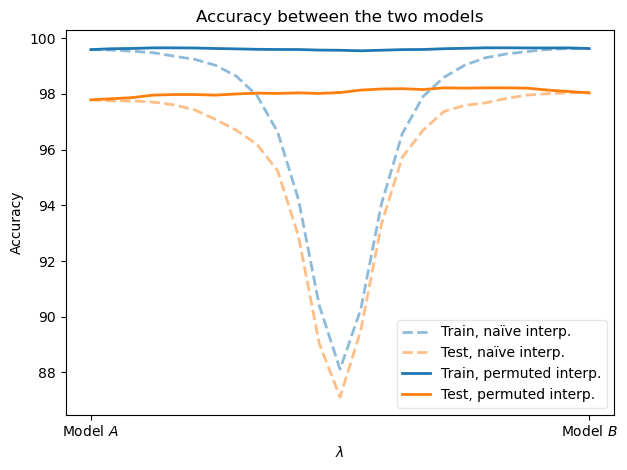

In [3]:
# Move to cpu
model_a.to("cpu")
model_b.to("cpu")

# Save old weights
model_b_old_params = copy.deepcopy(model_b.state_dict())
model_a_params = copy.deepcopy(model_a.state_dict())

# Fetch permutation spec for MLP, find best permutation, and apply it to model b 
permutation_spec = weight_matching.mlp_permutation_spec(3)
final_permutation = weight_matching.weight_matching(permutation_spec,
                                    utils.flatten_params(model_a), utils.flatten_params(model_b), verbose=0)
model_b_updated_params = weight_matching.apply_permutation(permutation_spec, final_permutation, utils.flatten_params(model_b))


# test against mnist
train_loader,test_loader = data.get_data_loaders(dataset="mnist", test_kwargs={'batch_size': 5000}, train_kwargs={'batch_size': 5000})

lambdas = torch.linspace(0, 1, steps=25)

test_acc_interp_clever = []
test_acc_interp_naive = []
train_acc_interp_clever = []
train_acc_interp_naive = []

test_loss_interp_clever = []
test_loss_interp_naive = []
train_loss_interp_clever = []
train_loss_interp_naive = []

# naive
model_b.load_state_dict(model_b_old_params)
for lam in tqdm(lambdas):
  naive_lerp_params = utils.lerp(lam, model_a_params, model_b_old_params)
  model_b.load_state_dict(naive_lerp_params)
  test_loss, acc = training.test(model_b.to(device), device, test_loader, verbose=0)
  test_acc_interp_naive.append(acc)
  test_loss_interp_naive.append(test_loss)
  train_loss, acc = training.test(model_b.to(device), device, train_loader, verbose=0)
  train_acc_interp_naive.append(acc)
  train_loss_interp_naive.append(train_loss)

# smart
model_b.load_state_dict(model_b_updated_params)
for lam in tqdm(lambdas):
  permuted_lerp_parmas = utils.lerp(lam, model_a_params, model_b_updated_params)
  model_b.load_state_dict(permuted_lerp_parmas)
  test_loss, acc = training.test(model_b.to(device), device, test_loader, verbose=0)
  test_acc_interp_clever.append(acc)
  test_loss_interp_naive.append(test_loss)
  train_loss, acc = training.test(model_b.to(device), device, train_loader, verbose=0)
  train_acc_interp_clever.append(acc)
  train_loss_interp_naive.append(train_loss)

fig = plot.plot_interp_acc(lambdas, train_acc_interp_naive, test_acc_interp_naive,
                train_acc_interp_clever, test_acc_interp_clever)
#plt.savefig(f"mnist_mlp_weight_matching_interp_accuracy_epoch.png", dpi=300)
